In [1]:
#Import necessary packages
import nest_asyncio
nest_asyncio.apply()
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import pandas as pd
import stan
import subprocess
import warnings
import networkx as nx
warnings.filterwarnings("ignore")

In [2]:
# The Hawkes process kernel used. Weibull Kernel
def kernel(p, t, beta):
    return (1.0-p)**(t**beta)-(1.0-p)**((t+1)**beta)

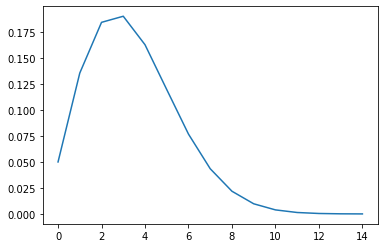

In [3]:
#Plot the Weibull distribution
p = 0.05
beta = 2.0
t = np.zeros(15)
f = np.zeros(15)

for i in range(len(t)):
    f[i] = kernel(p, i, beta)
plt.plot(f)
plt.show()

In [4]:
# Generate MHP's M=34
M=34
T=300
mu=np.random.rand(M)
mu=mu.reshape((M, 1))

p=0.05
beta=2.0

import networkx as nx
G = nx.karate_club_graph()
A=nx.to_numpy_array(G)
for i in range(34):
    A[i,i]=5.0

max_eval=np.linalg.eigvals(A)[0]

A=0.8*A/max_eval
print(A)

theta=A
print(theta)

def mvh_sim(mu, theta, p, beta, T, M):
    N=np.zeros([M,T])
    lam=np.zeros([M,T])

    for i in range(M):
        lam[i,0]=mu[i]
        N[i,0]=np.random.poisson(lam[i,0])

    for t in range(1,T):
        for i in range(M):
            lam[i,t]=mu[i]
            for j in range(M):
                for s in range(t):
                    lam[i,t]=lam[i,t]+theta[i,j]*kernel(p,t-s-1,beta)*N[j,s]
            N[i,t]=np.random.poisson(lam[i,t])
    return N,lam

N,lam=mvh_sim(mu, theta, p, beta, T, M)

[[0.14988253 0.11990603 0.14988253 ... 0.05995301 0.         0.        ]
 [0.11990603 0.14988253 0.17985904 ... 0.         0.         0.        ]
 [0.14988253 0.17985904 0.14988253 ... 0.         0.05995301 0.        ]
 ...
 [0.05995301 0.         0.         ... 0.14988253 0.11990603 0.11990603]
 [0.         0.         0.05995301 ... 0.11990603 0.14988253 0.14988253]
 [0.         0.         0.         ... 0.11990603 0.14988253 0.14988253]]
[[0.14988253 0.11990603 0.14988253 ... 0.05995301 0.         0.        ]
 [0.11990603 0.14988253 0.17985904 ... 0.         0.         0.        ]
 [0.14988253 0.17985904 0.14988253 ... 0.         0.05995301 0.        ]
 ...
 [0.05995301 0.         0.         ... 0.14988253 0.11990603 0.11990603]
 [0.         0.         0.05995301 ... 0.11990603 0.14988253 0.14988253]
 [0.         0.         0.         ... 0.11990603 0.14988253 0.14988253]]


In [5]:
#COmpute the ground truth mean diagonal and off-diagonal
off = []
diag = []
for i in range(34):
    for j in range(34):
        if i != j :
            off.append(theta[i,j])
        else:
            diag.append(theta[i,i])

In [6]:
print('{:.3f}'.format(np.mean(off)))
print('{:.3f}'.format(np.mean(diag)))

0.012
0.150


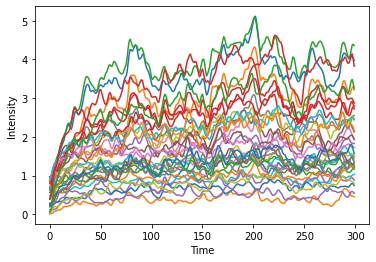

In [22]:
#Plot the intensity
plt.plot(np.transpose(lam))
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.savefig('intensity_karate.eps')
plt.show()

In [55]:
#Fix the nodes positions used later when plotting the network
layout_position = nx.spring_layout(G)

In [8]:
#FUnction to plot the network out of the genarted R matrix (called theta) out of the karate club graphs 
import networkx as nx

def plot_adj_matrix(theta, title, pos, filename = None):

    theta = np.round(theta, decimals=2)
    G = nx.from_numpy_array(theta)
    plt.show()

    self_loops = [(n, n) for n in G.nodes() if G.has_edge(n, n)]
    G.remove_edges_from(self_loops)

    
    #pos = nx.spring_layout(G)
    elarge = [(u,v) for (u,v,d) in G.edges(data = True) if d["weight"] > 0.1]
    esmall = [(u,v) for (u,v,d) in G.edges(data=True) if d["weight"] <= 0.1 and d["weight"] > 0.02]


    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='r')
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width = 3)
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width = 1, alpha = 0.5, edge_color='b', style='dashed')


    
    G1 = G.edge_subgraph(elarge).copy()
    G2 = G.edge_subgraph(esmall).copy()

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.title(title, size=20)

    
    if filename != None:
        plt.savefig(filename +'.eps')
    else:
        plt.show()
        

In [25]:
Naggr = np.sum(N, axis = 0)
ev, evec = np.linalg.eig(theta)
ev = np.real(ev)
evec = np.real(evec)
ev_max = np.max(ev)

In [26]:
#Estimate p and beta using Stan
model = """
data {
  int T;
  real N[T];
}
parameters {
  real<lower=0,upper=1> p;
  real<lower=0> beta;
  real<lower=0,upper=1> theta;
  real<lower=0> mu;
}
transformed parameters {
  vector[T] lam;

  lam[1] = mu;
  
  for (j in 2:T){
    lam[j]=mu;
    for(k in 1:(j-1)){
     lam[j] = lam[j]+theta*(pow(1.0-p,pow(j-k-1.0,beta))-pow(1.0-p,pow(j-k,beta)))*N[k];
    }
  }
}
model {
  theta ~ beta(1,1);
  p ~ beta(1,1);
  mu ~ cauchy(0,5); 
  beta ~ cauchy(0,5); 
  for (j in 1:T){
    target+=N[j]*log(lam[j])-lam[j];
  }
}
"""

In [27]:
data = {"T":300,"N": Naggr}
posterior = stan.build(model, data=data, random_seed=2)
fit = posterior.sample(num_chains=1, num_samples = 1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan__ipcsosu/model_xws5alzv.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling:  50% (1000/2000)
Sampling:  50% (1001/2000)
Sampling:  55% (1100/2000)
Sampling:  60% (1200/2000)
Sampling:  65% (1300/2000)
Sampling:  70% (1400/2000)
Sampling:  75% (1500/2000)
Sampling:  80% (1600/2000)
Sampling:  85% (1700/2000)
Sampling:  90% (1800/2000)
Sampling:  95% (1900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), 

In [28]:
p_est = np.mean(fit['p'])
beta_est = np.mean(fit['beta'])

In [29]:
print('{:.3f}'.format(p_est), ['{:.3f}'.format(np.percentile(fit['p'], 5)), '{:.3f}'.format(np.percentile(fit['p'],95))])
print('{:.3f}'.format(beta_est), ['{:.3f}'.format(np.percentile(fit['beta'], 5)), '{:.3f}'.format(np.percentile(fit['beta'],95))])

0.041 ['0.003', '0.142']
2.317 ['1.191', '3.571']


In [9]:
p_est = 0.041 #p
beta_est = 2.317 #beta

In [10]:
# Create linear regression from the multivariate Hawkes

def exact_theta(theta, mu):
    M = np.shape(theta)[0]
    theta_vect = np.ones(M*(M+1))
    
    for i in range(M):
        theta_vect[i] = mu[i] #fill the first M elements of the vector 
    cnt = i  #set the cnt value to the last increment of the last loop
    
    for i in range(M):
        for j in range(M):
            cnt+=1
            theta_vect[cnt] = theta[i,j]
    
    return theta_vect

def coef_vec2mat(theta_vect, M):
    theta_est = np.zeros([M,M])
    mu_est = np.zeros(M)
    for i in range(M):
        mu_est[i] = theta_vect[i]
    cnt = i
    for i in range(M):
        for j in range(M):
            cnt+=1
            theta_est[i,j] = theta_vect[cnt]
    return mu_est, theta_est

def create_linear_system(N, p_est, beta_est):
    M = np.shape(N)[0]
    T = np.shape(N)[1]
    y = np.zeros(M*T)
    X = np.zeros([M*T, M*(M+1)])
    cnt = -1
    for t in range(T):
        cnt2 = M-1
        for i in range(M):
            cnt+=1
            y[cnt] = N[i,t]
            X[cnt,i] = 1.0
            for j in range(M):
                cnt2+=1
                for s in range(t):
                    X[cnt, cnt2] += N[j,s]*kernel(p_est, t-s-1, beta_est)
    return y, X

def create_linear_system_diag(N, p_est, beta_est):
    T = len(N)
    y = np.zeros(T)
    X = np.zeros([T,2])
    for t in range(T):
        y[t] = N[t]
        X[t,0] = 1.0
        for s in range(t):
            X[t,1] += N[s]*kernel(p_est, t-s-1, beta_est)
    return y, X


def create_linear_system_offdiag(N, p_est, beta_est, theta_diag):
    M = np.shape(N)[0]
    T = np.shape(N)[1]
    y = np.zeros(M*T)
    X = np.zeros([M*T,(M*M+1)])
    cnt = -1
    for t in range(T):
        cnt2 = M-1
        for i in range(M):
            cnt += 1
            y[cnt] = N[i,t]
            X[cnt,i] = 1.0
            for j in range(M):
                if j !=i :
                    cnt2 += 1
                    for s in range(t):
                        X[cnt,cnt2] += kernel(p_est, t-s-1, beta_est)*N[j,s]
                else:
                    for s in range(t):
                        X[cnt,(M*M)] += kernel(p_est, t-s-1, beta_est)*N[j,s]*theta_diag[i]
    return y, X

def create_linear_system_fixdiag(N, p_est, beta_est, theta_diag):
    M = np.shape(N)[0]
    T = np.shape(N)[1]
    y = np.zeros(M*T)
    X = np.zeros([M*T, M*M])
    cnt = -1
    for t in range(T):
        cnt2 = M-1
        for i in range(M):
            cnt+=1
            y[cnt] = N[i,t]
            X[cnt,i] = 1.0
            for j in range(M):
                if i!=j:
                    cnt2+=1
                    for s in range(t):
                        X[cnt, cnt2] += N[j,s]*kernel(p_est, t-s-1, beta_est)
                else:
                    for s in range(t):
                        y[cnt] -= N[j,s]*kernel(p_est, t-s-1, beta_est)*theta_diag[i]
    return y, X

In [11]:
# Linear Estimate
def full_linear_estimate(N, p_est, beta_est, x, M):
    T = N.shape[1]
    N_train = (T//10)*x
    y, X = create_linear_system(N, p_est, beta_est)
    reg = LinearRegression(positive=True, fit_intercept=False).fit(X[0:N_train,:], y[0:N_train])
    mu_est, theta_est = coef_vec2mat(reg.coef_, M)
    
    yhat = np.matmul(X,reg.coef_)

    mse_train = np.mean((y[0:N_train]-yhat[0:N_train])**2)
    mse_test = np.mean((y[N_train:]-yhat[N_train:])**2) 
    #mse=np.mean((y[N_train:]-yhat[N_train:])**2)
    
    return mu_est, theta_est, mse_train, mse_test

In [12]:
# Ridge estimate method (Ridge for diag_param = 1 and Ridge Diag for diag_param = 0)
def ridge_estimate(N, p_est, beta_est, x, diag_param, M, Nsamp):
    T = N.shape[1]
    N_train = (T//10)*x 
    y,X = create_linear_system(N, p_est, beta_est)
    pfac = np.ones(X.shape[1])
    if diag_param == 1:
        cnt = -1
        cnt2 = M-1
        for i in range(M):
            pfac[i]=0.0
            cnt+=1
            for j in range(M):
                cnt2+=1
                if i==j:
                    pfac[cnt2]=0.0
    pd.DataFrame([Nsamp]).to_csv('Nsamp.csv',index=False,header=False)
    pd.DataFrame(X).to_csv('X.csv',index=False,header=False)
    pd.DataFrame(y).to_csv('y.csv',index=False,header=False)
    pd.DataFrame(pfac).to_csv('pfac.csv',index=False,header=False)
   

    subprocess.call("Rscript mvhawkes_glmnet.R", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    ridge_coef=pd.read_csv("glm_coefs.csv")
    
    mu_est, theta_est = coef_vec2mat(ridge_coef['x'], M)

    yhat = np.matmul(X, ridge_coef['x'])
    mse_train = np.mean((y[0:N_train]-yhat[0:N_train])**2)
    mse_test = np.mean((y[N_train:]-yhat[N_train:])**2)
    #mse=np.mean((y[N_train:]-yhat[N_train:])**2)

    return mu_est, theta_est, mse_train, mse_test


In [13]:
#Elastic Net Estimate (Elastic Net for diag_param = 1 and Elastic Net Diag for diag_param = 0)
def ridge_estimate_lasso(N, p_est, beta_est, x, diag_param, M, Nsamp):
    T = N.shape[1]
    N_train = (T//10)*x
    y,X = create_linear_system(N, p_est, beta_est)
    pfac = np.ones(X.shape[1])
    if diag_param == 1:
        cnt = -1
        cnt2 = M-1
        for i in range(M):
            pfac[i]=0.0
            cnt+=1
            for j in range(M):
                cnt2+=1
                if i==j:
                    pfac[cnt2]=0.0
    pd.DataFrame([Nsamp]).to_csv('Nsamp.csv',index=False,header=False)
    pd.DataFrame(X).to_csv('X.csv',index=False,header=False)
    pd.DataFrame(y).to_csv('y.csv',index=False,header=False)
    pd.DataFrame(pfac).to_csv('pfac.csv',index=False,header=False)
   

    subprocess.call("Rscript mvhawkes_glmnet_lasso.R", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    ridge_coef=pd.read_csv("glm_coefs.csv")
    
    mu_est, theta_est = coef_vec2mat(ridge_coef['x'], M)

    yhat = np.matmul(X, ridge_coef['x'])

    mse_train = np.mean((y[0:N_train]-yhat[0:N_train])**2)
    mse_test = np.mean((y[N_train:]-yhat[N_train:])**2)
    #mse=np.mean((y[N_train:]-yhat[N_train:])**2)
    return mu_est, theta_est, mse_train, mse_test

In [14]:
#Staged1
#from sklearn.linear_model import Ridge
def staged_estimate(N, p_est, beta_est, x, M):
    T = N.shape[1]
    N_train = x*(T//10)
    mu_diag=np.zeros(M)
    theta_diag=np.zeros(M)
    for i in range(M):
        y1,X1=create_linear_system_diag(N[i,:],p_est,beta_est)
        #reg1 = Ridge(alpha=1, fit_intercept=False).fit(X1[0:N_train,:], y1[0:N_train])
        reg1 = LinearRegression(positive=True,fit_intercept=False).fit(X1[0:N_train,:], y1[0:N_train])
    for i in range(M):        
        mu_diag[i]=reg1.coef_[0]
        theta_diag[i]=reg1.coef_[1]
        
        
    yoff, Xoff = create_linear_system_offdiag(N,p_est,beta_est,theta_diag)
    #regoff = Ridge(alpha=1, fit_intercept=False).fit(Xoff[0:N_train,:], yoff[0:N_train])
    regoff = LinearRegression(positive=True,fit_intercept=False).fit(Xoff[0:N_train,:], yoff[0:N_train])
    y_hatoff=np.matmul(Xoff,regoff.coef_)
    
    theta_est=np.zeros([M,M])
    mu_est=np.zeros(M)

    rho=regoff.coef_[-1]
   
    for i in range(M):
        mu_est[i]=regoff.coef_[i]
        theta_est[i,i]=rho*theta_diag[i]

    cnt2=i
    for i in range(M):
        for j in range(M):
            if i!=j:
                cnt2+=1
                theta_est[i,j]=regoff.coef_[cnt2]
            
            
    mse_train = np.mean((yoff[0:N_train]-y_hatoff[0:N_train])**2)
    mse_test =np.mean((yoff[N_train:]-y_hatoff[N_train:])**2)
    #mse=np.mean((yoff[N_train:]-y_hatoff[N_train:])**2)
    
    return mu_est, theta_est, mse_train, mse_test

In [15]:
#Staged2
def staged_fixed_estimate(N, p_est, beta_est, x, M):

    T = N.shape[1]
    N_train = (T//10)*x
    
    mu_diag = np.zeros(M)
    theta_diag = np.zeros(M)

    ybase = np.zeros(M*T)
    for i in range(M):
        y1, X1 = create_linear_system_diag(N[i,:], p_est, beta_est)
        #reg1 = Ridge(alpha=0.5, fit_intercept=False).fit(X1[0:N_train,:], y1[0:N_train])
        reg1 = LinearRegression(positive=True, fit_intercept=False).fit(X1[0:N_train:],y1[0:N_train])

        mu_diag[i] = reg1.coef_[0]
        theta_diag[i] = reg1.coef_[1]
        
    yoff, Xoff = create_linear_system_fixdiag(N, p_est, beta_est, theta_diag)
    #regoff = Ridge(alpha=1, fit_intercept=False).fit(Xoff[0:N_train,:], yoff[0:N_train])
    regoff = LinearRegression(positive=True, fit_intercept=False).fit(Xoff[0:N_train:],yoff[0:N_train])
    yhatoff = np.matmul(Xoff, regoff.coef_)

    theta_est = np.zeros([M,M])
    mu_est = np.zeros(M)

    for i in range(M):
        mu_est[i] = regoff.coef_[i]
        theta_est[i,i] = theta_diag[i]
    cnt2 = i
    for i in range(M):
        for j in range(M):
            if i!=j:
                cnt2+=1
                theta_est[i,j] = regoff.coef_[cnt2]

    mse_train = np.mean((yoff[0:N_train]-yhatoff[0:N_train])**2)
    mse_test = np.mean((yoff[N_train:]-yhatoff[N_train:])**2)
    #mse=np.mean((yoff[N_train:]-yhatoff[N_train:])**2)
    return mu_est, theta_est, mse_train, mse_test
                

In [16]:
# Run the Karate experiment with the different estimation methods over 100 simulation
Dfull= []
Drid  = []
Drid_lasso = []
Drid_lasso_diag = []
Dridiag = []
Dstage = []
Dfix = []


Ofull = []
Orid  = []
Orid_lasso = []
Orid_lasso_diag = []
Oridiag = []
Ostage = []
Ofix = []


mfull_train = []
mfull_test = []
mrid_train  = []
mrid_test  = []
mrid_lasso_train = []
mrid_lasso_test = []
mrid_lasso_diag_train = []
mrid_lasso_diag_test = []
mridiag_train = []
mridiag_test = []
mstage_train = []
mstage_test = []
mfix_train = []
mfix_test = []


M = 34
Nsamp = 300
number_of_simulations = 100
x = 7

for k in range(number_of_simulations):
    N, lam = mvh_sim(mu, theta, p, beta, T, M)
    mu_full, theta_full, mse_full_train, mse_full_test  = full_linear_estimate(N, p_est, beta_est, x, M)
    mu_ridge_diag, theta_ridge_diag, mse_ridge_diag_train, mse_ridge_diag_test = ridge_estimate(N, p_est, beta_est, x, 1, M, Nsamp)
    mu_ridge, theta_ridge, mse_ridge_train, mse_ridge_test  = ridge_estimate(N,p_est, beta_est, x, 0, M, Nsamp)
    mu_ridge_lasso_diag, theta_ridge_lasso_diag, mse_ridge_lasso_diag_train,mse_ridge_lasso_diag_test = ridge_estimate_lasso(N, p_est, beta_est, x, 0, M, Nsamp)
    mu_ridge_lasso, theta_ridge_lasso, mse_ridge_lasso_train, mse_ridge_lasso_test = ridge_estimate_lasso(N, p_est, beta_est, x, 1, M, Nsamp)
    mu_stage_fix, theta_stage_fix, mse_stage_fix_train, mse_stage_fix_test = staged_fixed_estimate(N, p_est, beta_est, x, M)
    mu_stage, theta_stage, mse_stage_train, mse_stage_test = staged_estimate(N, p_est, beta_est, x, M)

    mfull_train.append(mse_full_train)
    mfull_test.append(mse_full_test)
    mrid_train.append(mse_ridge_train)
    mrid_test.append(mse_ridge_test)
    mridiag_train.append(mse_ridge_diag_train)
    mridiag_test.append(mse_ridge_diag_test)
    mrid_lasso_train.append(mse_ridge_lasso_train)
    mrid_lasso_test.append(mse_ridge_lasso_test)
    mrid_lasso_diag_train.append(mse_ridge_lasso_diag_train)
    mrid_lasso_diag_test.append(mse_ridge_lasso_diag_test)
    mstage_train.append(mse_stage_train)
    mstage_test.append(mse_stage_test)
    mfix_train.append(mse_stage_fix_train)
    mfix_test.append(mse_stage_fix_test)
    

    if k==0:
        theta1 = theta_full/number_of_simulations
        theta2 = theta_ridge/number_of_simulations
        theta3 = theta_ridge_lasso/number_of_simulations
        theta4 = theta_ridge_lasso_diag/number_of_simulations
        theta5 = theta_ridge_diag/number_of_simulations
        theta6 = theta_stage/number_of_simulations
        theta7 = theta_stage_fix/number_of_simulations
    else:
        theta1 += theta_full/number_of_simulations
        theta2 += theta_ridge/number_of_simulations
        theta3 += theta_ridge_lasso/number_of_simulations
        theta4 += theta_ridge_lasso_diag/number_of_simulations
        theta5 += theta_ridge_diag/number_of_simulations
        theta6 += theta_stage/number_of_simulations
        theta7 += theta_stage_fix/number_of_simulations
        
    for i in range(M):
        Dfull.append(theta_full[i,i])
        Drid.append(theta_ridge[i,i])
        Drid_lasso.append(theta_ridge_lasso[i,i])
        Drid_lasso_diag.append(theta_ridge_lasso_diag[i,i])
        Dridiag.append(theta_ridge_diag[i,i])
        Dstage.append(theta_stage[i,i])
        Dfix.append(theta_stage_fix[i,i])

        for j in range(M):
            if i!=j:
                Ofull.append(theta_full[i,j])
                Orid.append(theta_ridge[i,j])
                Orid_lasso.append(theta_ridge_lasso[i,j])
                Orid_lasso_diag.append(theta_ridge_lasso_diag[i,j])
                Oridiag.append(theta_ridge_diag[i,j])
                Ostage.append(theta_stage[i,j])
                Ofix.append(theta_stage_fix[i,j])
    
    print(k, np.mean(mfull_train), np.mean(mfull_test), np.mean(mrid_train), np.mean(mrid_test),  
          np.mean(mridiag_train), np.mean(mridiag_test), np.mean(mrid_lasso_train), np.mean(mrid_lasso_test),
          np.mean(mrid_lasso_diag_train), np.mean(mrid_lasso_diag_test), np.mean(mstage_train), np.mean(mstage_test), 
          np.mean(mfix_train), np.mean(mfix_test))
    print(k, np.mean(Dfull), np.mean(Drid), np.mean(Dridiag),  np.mean(Drid_lasso), np.mean(Drid_lasso_diag), np.mean(Dstage), np.mean(Dfix))
    print(k, np.mean(Ofull), np.mean(Orid), np.mean(Oridiag), np.mean(Orid_lasso),  np.mean(Orid_lasso_diag), np.mean(Ostage), np.mean(Ofix))
    print('')

0 0.19108894259184397 892.8572331277696 0.6578346224693308 1.7440685925113182 0.5348222469921908 1.7108068451407488 0.5469066854338391 1.7133811081746233 0.5797961154901213 1.7005696482361599 0.19108894259184397 893.0258726472779 0.21816685515210346 864.7749329041319
0 0.0 0.04016775052269893 0.0707805412220288 0.11230013567054697 0.02811407003097571 0.0 0.355617499934434
0 0.3627085537975503 0.033347215336774684 0.0270700684202582 0.021076422203349075 0.028933725544536854 0.3612841012009619 0.3532073890264292

1 0.32053502237121934 750.7272082207393 0.7930801976455907 1.7014237562177192 0.6460075508651426 1.683110148236138 0.6547700174720259 1.6768979579819794 0.7265893195827213 1.6628670053120551 0.3205350223712194 750.8115279804936 0.357813485980987 723.7610234663453
1 0.0 0.041141636561861955 0.09622967935324302 0.11648841756880624 0.030477153694377142 0.0 0.334233545244742
1 0.29791668294234896 0.03360557337067754 0.02466970110002391 0.021212063257797405 0.029642295314454743 0.297

In [45]:
karate_table = {' ': ['Linear', 'Ridge', 'Ridge Diag', 'Elastic Net', 'Elastic Net Diag', 'Staged1', 'Staged2'],
               'Train MSE': ['{:.3f}'.format(np.mean(mfull_train)), '{:.3f}'.format(np.mean(mrid_train)),
                             '{:.3f}'.format(np.mean(mridiag_train)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_train)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_diag_train)), '{:.3f}'.format(np.mean(mstage_train)), 
                                      '{:.3f}'.format(np.mean(mfix_train))],
                'Test MSE': ['{:.3f}'.format(np.mean(mfull_test)), '{:.3f}'.format(np.mean(mrid_test)),
                             '{:.3f}'.format(np.mean(mridiag_test)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_test)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_diag_test)), '{:.3f}'.format(np.mean(mstage_test)), 
                                      '{:.3f}'.format(np.mean(mfix_test))],
              'R Diagonal': ['{:.3f}'.format(np.mean(Dfull)), '{:.3f}'.format(np.mean(Drid)), '{:.3f}'.format(np.mean(Dridiag)),
                             '{:.3f}'.format(np.mean(Drid_lasso)),
                                      '{:.3f}'.format(np.mean(Drid_lasso_diag)), '{:.3f}'.format(np.mean(Dstage)), 
                             '{:.3f}'.format(np.mean(Dfix))],
              'R Off diagonal': ['{:.3f}'.format(np.mean(Ofull)), '{:.3f}'.format(np.mean(Orid)), '{:.3f}'.format(np.mean(Oridiag)), 
                                 '{:.3f}'.format(np.mean(Orid_lasso)),
                                      '{:.3f}'.format(np.mean(Orid_lasso_diag)), '{:.3f}'.format(np.mean(Ostage)), 
                                 '{:.3f}'.format(np.mean(Ofix))]}

In [46]:
pd.DataFrame(karate_table)

,,Train MSE,Test MSE,R Diagonal,R Off diagonal
0,Linear,0.337,369.910,0.000,0.186
1,Ridge,0.737,1.630,0.044,0.034
2,Ridge Diag,0.599,1.623,0.123,0.022
3,Elastic Net,0.651,1.624,0.157,0.015
4,Elastic Net Diag,0.659,1.597,0.040,0.029
5,Staged1,0.337,370.870,0.000,0.186
6,Staged2,0.364,347.433,0.295,0.173


In [47]:
import pandas as pd
table_karate = pd.DataFrame(karate_table)
table_karate.to_csv('Karate_simulation_results.csv', index = None)

In [48]:
pd.read_csv('Karate_simulation_results.csv')

,,Train MSE,Test MSE,R Diagonal,R Off diagonal
0,Linear,0.337,369.910,0.000,0.186
1,Ridge,0.737,1.630,0.044,0.034
2,Ridge Diag,0.599,1.623,0.123,0.022
3,Elastic Net,0.651,1.624,0.157,0.015
4,Elastic Net Diag,0.659,1.597,0.040,0.029
5,Staged1,0.337,370.870,0.000,0.186
6,Staged2,0.364,347.433,0.295,0.173


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


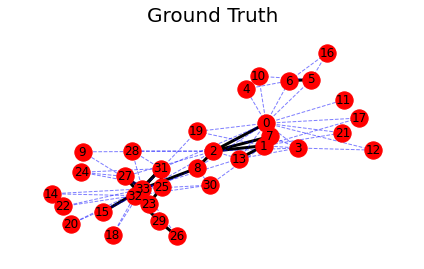

In [56]:
plot_adj_matrix(theta, 'Ground Truth', layout_position,  'ground_truth_karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


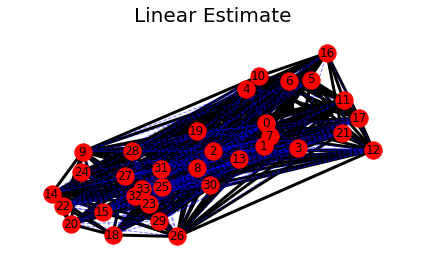

In [57]:
plot_adj_matrix(theta1, 'Linear Estimate', layout_position, 'Linear_Estimate_Karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


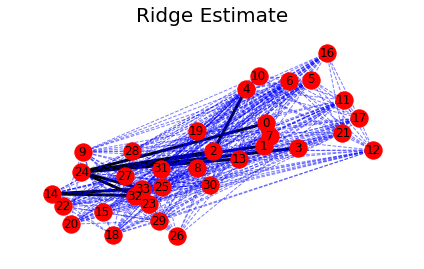

In [58]:
plot_adj_matrix(theta2, 'Ridge Estimate', layout_position, 'Ridge_Estimate_Karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


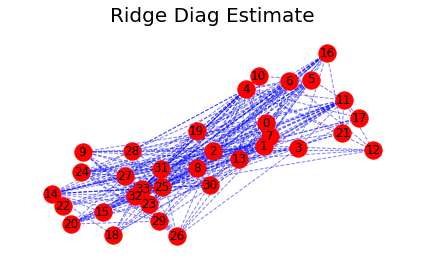

In [59]:
plot_adj_matrix(theta5, 'Ridge Diag Estimate', layout_position, 'Ridge_Diagonal_Estimate_Karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


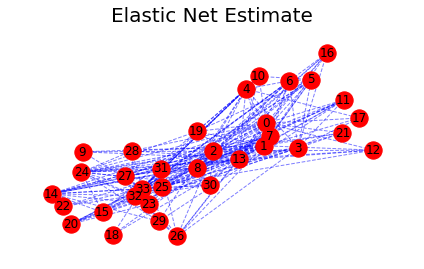

In [60]:
plot_adj_matrix(theta3, 'Elastic Net Estimate', layout_position, 'Elastic_Net_Estimate_Karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


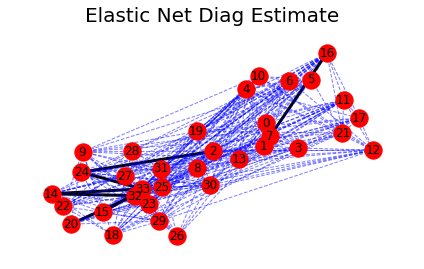

In [61]:
plot_adj_matrix(theta4, 'Elastic Net Diag Estimate', layout_position, 'Elastic_Net_Diagonal_Estimate_Karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


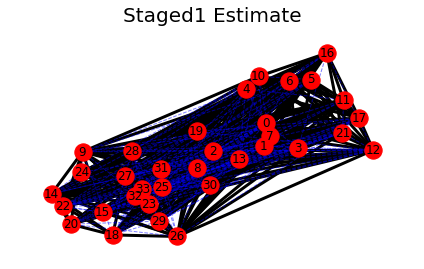

In [62]:
plot_adj_matrix(theta6, 'Staged1 Estimate', layout_position, 'Staged1_Estimate_Karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


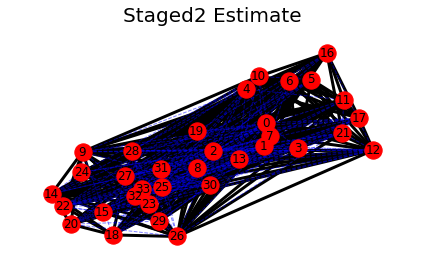

In [63]:
plot_adj_matrix(theta7, 'Staged2 Estimate', layout_position, 'Staged2_Estimate_Karate')

# Real Data experiment

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


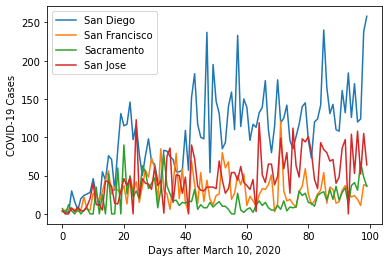

In [64]:
county_data = pd.read_csv('county_data.csv')
county_names = ['San Diego', 'San Francisco', 'Sacramento', 'San Jose']
county_data = np.array(county_data)

N_real_data = np.transpose(county_data)
plt.plot(N_real_data.transpose())
plt.legend(county_names)
plt.xlabel('Days after March 10, 2020')
plt.ylabel('COVID-19 Cases')
plt.savefig('real_data_covid_cases.eps')
plt.show()

In [65]:
Naggr_real_data = np.sum(N_real_data, axis=0)

In [16]:
hawkes_data = {"T": 100, "N": Naggr_real_data}
posterior = stan.build(model, data=hawkes_data, random_seed=2)
fit = posterior.sample(num_chains=1, num_samples = 1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan__ipcsosu/model_xws5alzv.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling:  50% (1001/2000)
Sampling:  55% (1100/2000)
Sampling:  60% (1200/2000)
Sampling:  65% (1300/2000)
Sampling:  70% (1400/2000)
Sampling:  75% (1500/2000)
Sampling:  80% (1600/2000)
Sampling:  85% (1700/2000)
Sampling:  90% (1800/2000)
Sampling:  95% (1900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received dur

In [17]:
p_est_real_data = np.mean(fit['p'])
beta_est_real_data = np.mean(fit['beta'])

In [18]:
print('{:.4f}'.format(p_est_real_data), ['{:.4f}'.format(np.percentile(fit['p'], 5)), '{:.4f}'.format(np.percentile(fit['p'],95))])
print('{:.4f}'.format(beta_est_real_data), ['{:.4f}'.format(np.percentile(fit['beta'], 5)), '{:.4f}'.format(np.percentile(fit['beta'],95))])

0.0004 ['0.0001', '0.0010']
4.4769 ['3.8432', '5.1607']


In [66]:
p_est_real_data = 0.0004
beta_est_real_data = 4.4769

In [68]:
#Compute the mean diagonal and off-diagonal of the reproduction matrix for the real data
Dfull = []
Drid  = []
Drid_lasso = []
Drid_lasso_diag = []
Dridiag = []
Dstage = []
Dfix = []
Dind = []

Ofull = []
Orid  = []
Orid_lasso = []
Orid_lasso_diag = []
Oridiag = []
Ostage = []
Ofix = []


mfull_train = []
mfull_test = []
mrid_train  = []
mrid_test  = []
mrid_lasso_train = []
mrid_lasso_test = []
mrid_lasso_diag_train = []
mrid_lasso_diag_test = []
mridiag_train = []
mridiag_test = []
mstage_train = []
mstage_test = []
mfix_train = []
mfix_test = []

M = 4
Nsamp = 100
x = 7
N = np.transpose(county_data)
p_est = p_est_real_data
beta_est = beta_est_real_data
    
mu_full, theta_full, mse_full_train, mse_full_test  = full_linear_estimate(N, p_est, beta_est, x, M)
mu_ridge_diag, theta_ridge_diag, mse_ridge_diag_train, mse_ridge_diag_test = ridge_estimate(N, p_est, beta_est, x, 1, M, Nsamp)
mu_ridge, theta_ridge, mse_ridge_train, mse_ridge_test  = ridge_estimate(N,p_est, beta_est, x, 0, M, Nsamp)
mu_ridge_lasso_diag, theta_ridge_lasso_diag, mse_ridge_lasso_diag_train,mse_ridge_lasso_diag_test = ridge_estimate_lasso(N, p_est, beta_est, x, 0, M, Nsamp)
mu_ridge_lasso, theta_ridge_lasso, mse_ridge_lasso_train, mse_ridge_lasso_test = ridge_estimate_lasso(N, p_est, beta_est, x, 1, M, Nsamp)
mu_stage_fix, theta_stage_fix, mse_stage_fix_train, mse_stage_fix_test = staged_fixed_estimate(N, p_est, beta_est, x, M)
mu_stage, theta_stage, mse_stage_train, mse_stage_test = staged_estimate(N, p_est, beta_est, x, M)


mfull_train.append(mse_full_train)
mfull_test.append(mse_full_test)
mrid_train.append(mse_ridge_train)
mrid_test.append(mse_ridge_test)
mridiag_train.append(mse_ridge_diag_train)
mridiag_test.append(mse_ridge_diag_test)
mrid_lasso_train.append(mse_ridge_lasso_train)
mrid_lasso_test.append(mse_ridge_lasso_test)
mrid_lasso_diag_train.append(mse_ridge_lasso_diag_train)
mrid_lasso_diag_test.append(mse_ridge_lasso_diag_test)
mstage_train.append(mse_stage_train)
mstage_test.append(mse_stage_test)
mfix_train.append(mse_stage_fix_train)
mfix_test.append(mse_stage_fix_test)


    
for i in range(M):
    Dfull.append(theta_full[i,i])
    Drid.append(theta_ridge[i,i])
    Drid_lasso.append(theta_ridge_lasso[i,i])
    Drid_lasso_diag.append(theta_ridge_lasso_diag[i,i])
    Dridiag.append(theta_ridge_diag[i,i])
    Dstage.append(theta_stage[i,i])
    Dfix.append(theta_stage_fix[i,i])

    for j in range(M):
        if i!=j:
            Ofull.append(theta_full[i,j])
            Orid.append(theta_ridge[i,j])
            Orid_lasso.append(theta_ridge_lasso[i,j])
            Orid_lasso_diag.append(theta_ridge_lasso_diag[i,j])
            Oridiag.append(theta_ridge_diag[i,j])
            Ostage.append(theta_stage[i,j])
            Ofix.append(theta_stage_fix[i,j])
            
print(k, np.mean(mfull_train), np.mean(mfull_test), np.mean(mrid_train), np.mean(mrid_test),  
      np.mean(mridiag_train), np.mean(mridiag_test), np.mean(mrid_lasso_train), np.mean(mrid_lasso_test),
      np.mean(mrid_lasso_diag_train), np.mean(mrid_lasso_diag_test), np.mean(mstage_train), np.mean(mstage_test), 
      np.mean(mfix_train), np.mean(mfix_test))
print(k, np.mean(Dfull), np.mean(Drid), np.mean(Dridiag),  np.mean(Drid_lasso), np.mean(Drid_lasso_diag), np.mean(Dstage), np.mean(Dfix))
print(k, np.mean(Ofull), np.mean(Orid), np.mean(Oridiag), np.mean(Orid_lasso),  np.mean(Orid_lasso_diag), np.mean(Ostage), np.mean(Ofix))
print('')

99 117.56700915691958 4323.397313428928 183.46994064331543 809.9356590946205 182.83249135075943 800.4460628647719 181.49614348185003 798.6398763455346 175.86858370908305 797.4031928379455 120.37302036901079 4461.879390706119 121.44805387900979 3993.2565305511666
99 0.44835753515035454 0.4112821190551295 0.6471151199893584 0.6688998892190505 0.5059026668988374 0.13932494296682998 0.6762914939253112
99 0.33657047995250866 0.17545489986531393 0.07069470472120552 0.0650913517408087 0.13792135765831454 0.43669837035789816 0.2953591549627174



In [69]:
real_data_table = {' ': ['Linear', 'Ridge', 'Ridge Diag', 'Elastic Net', 'Elastic Net Diag', 'Staged1', 'Staged2'],
               'Train MSE': ['{:.3f}'.format(np.mean(mfull_train)), '{:.3f}'.format(np.mean(mrid_train)),
                             '{:.3f}'.format(np.mean(mridiag_train)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_train)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_diag_train)), '{:.3f}'.format(np.mean(mstage_train)), 
                                      '{:.3f}'.format(np.mean(mfix_train))],
                'Test MSE': ['{:.3f}'.format(np.mean(mfull_test)), '{:.3f}'.format(np.mean(mrid_test)),
                             '{:.3f}'.format(np.mean(mridiag_test)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_test)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_diag_test)), '{:.3f}'.format(np.mean(mstage_test)), 
                                      '{:.3f}'.format(np.mean(mfix_test))],
              'R Diagonal': ['{:.3f}'.format(np.mean(Dfull)), '{:.3f}'.format(np.mean(Drid)), '{:.3f}'.format(np.mean(Dridiag)),
                             '{:.3f}'.format(np.mean(Drid_lasso)),
                                      '{:.3f}'.format(np.mean(Drid_lasso_diag)), '{:.3f}'.format(np.mean(Dstage)), 
                             '{:.3f}'.format(np.mean(Dfix))],
              'R Off diagonal': ['{:.3f}'.format(np.mean(Ofull)), '{:.3f}'.format(np.mean(Orid)), '{:.3f}'.format(np.mean(Oridiag)), 
                                 '{:.3f}'.format(np.mean(Orid_lasso)),
                                      '{:.3f}'.format(np.mean(Orid_lasso_diag)), '{:.3f}'.format(np.mean(Ostage)), 
                                 '{:.3f}'.format(np.mean(Ofix))]}

In [70]:
pd.DataFrame(real_data_table)

,,Train MSE,Test MSE,R Diagonal,R Off diagonal
0,Linear,117.567,4323.397,0.448,0.337
1,Ridge,183.470,809.936,0.411,0.175
2,Ridge Diag,182.832,800.446,0.647,0.071
3,Elastic Net,181.496,798.640,0.669,0.065
4,Elastic Net Diag,175.869,797.403,0.506,0.138
5,Staged1,120.373,4461.879,0.139,0.437
6,Staged2,121.448,3993.257,0.676,0.295


In [71]:
import pandas as pd
table_real_data = pd.DataFrame(real_data_table)
table_real_data.to_csv('real_data_results.csv', index = None)

In [72]:
pd.read_csv('real_data_results.csv')

,,Train MSE,Test MSE,R Diagonal,R Off diagonal
0,Linear,117.567,4323.397,0.448,0.337
1,Ridge,183.470,809.936,0.411,0.175
2,Ridge Diag,182.832,800.446,0.647,0.071
3,Elastic Net,181.496,798.640,0.669,0.065
4,Elastic Net Diag,175.869,797.403,0.506,0.138
5,Staged1,120.373,4461.879,0.139,0.437
6,Staged2,121.448,3993.257,0.676,0.295
